### Load Dependencies

In [1]:
import requests
import json
from datetime import datetime, timedelta
import os
from unittest.mock import patch
import boto3

### Some constants

In [2]:
# Define locations
locations = {
    "us-west-2": (43.8041334, -120.5542012),
    "us-west-1": (38.8375215, -120.8958242),
}

start_date = datetime(2023, 6, 1, 0, 0, 0)

end_date = datetime(2023, 6, 30, 0, 0, 0)

### Load Carbon Data

In [16]:
# Function to query the API
def query_api(start, end, lat, lon, token):
    url = f"https://api-access.electricitymaps.com/free-tier/carbon-intensity/past-range?lat={lat}&lon={lon}&start={start}&end={end}"
    headers = {"auth-token": token}
    response = requests.get(url, headers=headers, timeout=10)
    if response.status_code == 200:
        return response.json()["data"]
    else:
        print(f"Error querying API: {response.status_code}")
        return []

def run():
    for location, (latitude, longitude) in locations.items():
        current_start = start_date - timedelta(days=7) # Start 7 days before the start date
        combined_data = []

        while current_start < end_date:
            current_end = current_start + timedelta(days=10)
            if current_end > end_date:
                current_end = end_date
            data = query_api(
                current_start, current_end, latitude, longitude, os.environ.get("ELECTRICITY_MAPS_AUTH_TOKEN")
            )
            combined_data.extend(data)
            current_start = current_end + timedelta(days=1)

        # Save the combined data to a file
        output_file = f"./data/carbon/{location}_carbon_data.json"
        with open(output_file, "w") as f:
            json.dump(combined_data, f)

        print(f"Data combined and saved to {output_file}")


if __name__ == "__main__":
    run()

Data combined and saved to ./data/carbon/us-west-2_carbon_data.json
Data combined and saved to ./data/carbon/us-west-1_carbon_data.json


### Create Carbon Collector Logs

In [18]:
import json
import math
import os
from datetime import datetime, timedelta
from collections import defaultdict

def calculate_distance(lat1, lon1, lat2, lon2):
    r = 6371.0  # Earth radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return r * c

def process_and_store_carbon_data_for_regions(input_file, output_folder, regions_info, current_region):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists
    
    with open(input_file, 'r') as file:
        data = json.load(file)
    
    # For each day between start_date and end_date
    for day in range((end_date - start_date).days + 1):
        current_date = start_date + timedelta(days=day)

        # Get all the data for the previous 7 days
        previous_7_days_data = [entry for entry in data if datetime.strptime(entry['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').date() >= (current_date - timedelta(days=7)).date() and datetime.strptime(entry['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').date() < current_date.date()]

        # Calculate the average carbon intensity for the previous 7 days
        if not previous_7_days_data:
            continue
        overall_sum = sum(item['carbonIntensity'] for item in previous_7_days_data)
        overall_avg = overall_sum / len(previous_7_days_data)

        # Calculate the average carbon intensity for each hour of the day
        hourly_averages = defaultdict(list)
        for item in previous_7_days_data:
            hour = datetime.strptime(item['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ').hour
            hourly_averages[hour].append(item['carbonIntensity'])

        hourly_avg = {hour: sum(values) / len(values) for hour, values in hourly_averages.items()}

        # Calculate the distances between the regions
        transmission_distances = {
            f"aws:{region_key}": calculate_distance(regions_info[current_region][0], regions_info[current_region][1], regions_info[region_key][0], regions_info[region_key][1]) for region_key in regions_info
        }
    
        # Assemble the result dictionary
        result_dict = {
            "averages": {
                "overall": {"carbon_intensity": overall_avg},
                **{str(hour): {"carbon_intensity": avg} for hour, avg in hourly_avg.items()}
            },
            "units": "gCO2eq/kWh",
            "transmission_distances": transmission_distances
        }

        # Store the result
        day_folder = os.path.join(output_folder, current_date.strftime('%Y-%m-%d'))
        os.makedirs(day_folder, exist_ok=True)
        with open(os.path.join(day_folder, 'data.json'), 'w') as outfile:
            json.dump(result_dict, outfile, indent=4)

for region in locations:
    process_and_store_carbon_data_for_regions(f"./data/carbon/{region}_carbon_data.json", f"./data/collected_carbon/{region}", locations, region)

### Get Data from the Home Region

For each benchmark:
1. Deploy the benchmark (optimally without any constraints) to the home region (which should be one of the regions we eventually also want to take into consideration).
2. Run the benchmark for a time (use the `invoke_serverless_function_uniform.sh` script to do so). I used it for example like this:
```bash
poetry run ./invoke_serverless_function_uniform.sh dna_visualization 0.0.1 200 3600
```
3. Use the following small script to log sync the data and store it locally.

In [3]:
# Define the benchmarks:
benchmarks = ["dna_visualization-0.0.1"]

benchmark_input_data = {
    "dna_visualization-0.0.1": '{"gen_file_name": "small_sequence.gb"}'
}

#### Log Sync

In [11]:
from multi_x_serverless.syncers.log_syncer import LogSyncWorkflow
from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.common.constants import DEPLOYMENT_MANAGER_RESOURCE_TABLE, GLOBAL_TIME_ZONE

region_clients = {}
endpoints = Endpoints()

# This assumes that the run happened in the last 24 hours
time_intervals = [(datetime.now(GLOBAL_TIME_ZONE) - timedelta(days=1), datetime.now(GLOBAL_TIME_ZONE))]

def log_sync(output_dir, workflow_id):
    deployment_manager_config_str = endpoints.get_deployment_manager_client().get_value_from_table(
        DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
    )

    raw_data_dir = output_dir
    os.makedirs(raw_data_dir, exist_ok=True)

    def mock_upload_data(self, data_for_upload: str):
        with open(f"{raw_data_dir}/data.json", "w") as f:
            f.write(data_for_upload)

    with patch.object(LogSyncWorkflow, "_upload_data", mock_upload_data):
        log_sync_workflow = LogSyncWorkflow(
            workflow_id,
            region_clients,
            deployment_manager_config_str,
            time_intervals,
            endpoints.get_datastore_client(),
            {}
        )
        log_sync_workflow.sync_workflow()

#### Invoke Log Sync

In [ ]:
for workflow_id in benchmarks:
    log_sync(f"./data/run_data/home_region/{workflow_id}", workflow_id)

#### Workflow Collect

In [4]:
from multi_x_serverless.data_collector.components.workflow.workflow_retriever import WorkflowRetriever
from multi_x_serverless.data_collector.components.data_collector import DataCollector

workflow_retriever = WorkflowRetriever(None)

def workflow_collect(input_dir, output_dir):
    with open(input_dir, "r") as f:
        data = f.read()

    workflow_summary = workflow_retriever._transform_workflow_summary(
        data,
    )

    os.makedirs(output_dir, exist_ok=True)

    with open(f"{output_dir}/data.json", "w") as f:
        json.dump(workflow_summary, f, indent=4)

#### Invoke Workflow Collect

In [14]:
for workflow_id in benchmarks:
    workflow_collect(f"./data/run_data/home_region/{workflow_id}/data.json", f"./data/collected_workflow/{workflow_id}/home_region")

### Run the Deployment Algorithm

We need to run the deployment algorithm for the days between the start and end date. We will run it every day and store the results locally in files.
Additionally, we need to provide the data collected by a specific workflow as the input to the workflow loader.

**TODO BEFORE the following is executed:** For each of the involved benchmarks we need to actually have some data from the home region. So please do **Get Data from the Home Region** first.

In [11]:
from multi_x_serverless.common.constants import GLOBAL_SYSTEM_REGION, DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE
from multi_x_serverless.routing.workflow_config import WorkflowConfig
from multi_x_serverless.routing.deployment_algorithms.stochastic_heuristic_deployment_algorithm import StochasticHeuristicDeploymentAlgorithm
from multi_x_serverless.routing.deployment_input.components.loaders.carbon_loader import CarbonLoader
from multi_x_serverless.routing.deployment_input.components.loaders.region_viability_loader import RegionViabilityLoader
from multi_x_serverless.routing.deployment_algorithms.deployment_algorithm import DeploymentAlgorithm
from multi_x_serverless.routing.deployment_input.components.loaders.workflow_loader import WorkflowLoader

# Define the constraint configurations
constraint_configurations = {
    "no_constraints": {
        "constraints": {
            "hard_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "soft_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "priority_order": ["carbon", "cost", "runtime"],
        }
    },
    "five_percent_runtime_constraint": {
        "constraints": {
            "hard_resource_constraints": {"cost": None, "runtime": {"type": "relative", "value": 105}, "carbon": None},
            "soft_resource_constraints": {"cost": None, "runtime": None, "carbon": None},
            "priority_order": ["carbon", "cost", "runtime"],
        }
    },
}

dynamodb_client = boto3.client('dynamodb', region_name=GLOBAL_SYSTEM_REGION)
for benchmark in benchmarks:
    response = dynamodb_client.get_item(TableName=DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE, Key={"key": {"S": benchmark}})
    item = response.get("Item")
    workflow_config_from_table = item["value"]["S"]

    workflow_config_dict = json.loads(json.loads(workflow_config_from_table).get("workflow_config"))
    for configuration_name, configuration in constraint_configurations.items():
        workflow_config_dict["constraints"] = configuration["constraints"]
        workflow_config = WorkflowConfig(workflow_config_dict)

        for day in range((end_date - start_date).days + 1):
            current_date = start_date + timedelta(days=day)

            def mock_carbon_loader_setup(self, available_regions: set[str]):
                real_available_regions = list(locations.keys())
                loaded_carbon_data = {}
                for region in real_available_regions:
                    carbon_data_path = f'./data/collected_carbon/{region}/{current_date.strftime("%Y-%m-%d")}/data.json'
                    with open(carbon_data_path, 'r') as file:
                        loaded_carbon_data[f'aws:{region}'] = json.load(file)
                self._carbon_data = loaded_carbon_data

            def mock_workflow_loader_setup(self, workflow_id: str):
                collected_data_dir = f"./data/collected_workflow/{workflow_id}/home_region/data.json"

                with open(collected_data_dir, "r") as f:
                    self._workflow_data = json.load(f)

            def mock_region_viability_setup(self):
                self._available_regions = [f'aws:{region}' for region in locations.keys()]

            def mock_upload_result(self, result: dict):
                result_path = f'./data/deployment_results/{benchmark}/{configuration_name}/'
                os.makedirs(result_path, exist_ok=True)
                with open(os.path.join(result_path, f'{current_date.strftime("%Y-%m-%d")}.json'), 'w') as file:
                    json.dump(result, file, indent=4)

            with patch.object(CarbonLoader, 'setup', new=mock_carbon_loader_setup), patch.object(RegionViabilityLoader, 'setup', new=mock_region_viability_setup), patch.object(DeploymentAlgorithm, '_upload_result', new=mock_upload_result), patch.object(WorkflowLoader, 'setup', new=mock_workflow_loader_setup):
                algorithm = StochasticHeuristicDeploymentAlgorithm(workflow_config)
                algorithm.run([f"{i}" for i in range(24)])

### Run new experiments for the new deployments

Now since we have the new deployments, we can run the experiments for them. We don't need to run all experiments, basically we need to run all the combinations of the regions involved. For this we need to iterate over the potential deployments, find combinations of regions that are not yet collected and run the experiments for them. The following script will do this on a per benchmark basis.

In [5]:
# Choose which benckmark to run
workflow_id = benchmarks[0]

#### Get unique new deployments for this benchmark

In [23]:
deployment_result_path = f'./data/deployment_results/{workflow_id}'

unique_instance_region_combinations = set()

# Iterate over all results, retrieving the combinations of instances and regions
for directory in os.listdir(deployment_result_path):
    if not os.path.isdir(os.path.join(deployment_result_path, directory)):
        continue
    for file in os.listdir(os.path.join(deployment_result_path, directory)):
        with open(os.path.join(deployment_result_path, directory, file), 'r') as f:
            data = json.load(f)
        for time_key, deployment in data["time_keys_to_staging_area_data"].items():
            deployment_str = json.dumps(deployment)
            unique_instance_region_combinations.add(deployment_str)

# Store the unique combinations
with open(f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json', 'w') as f:
    json.dump(list(unique_instance_region_combinations), f, indent=4)

#### Re-deploy all deployments

Before we can run the experiments we need the code to be in the right regions


In [7]:
from multi_x_serverless.deployment.common.deploy.deployer import create_default_deployer
from multi_x_serverless.common.constants import (
    DEPLOYMENT_MANAGER_RESOURCE_TABLE
)
from multi_x_serverless.deployment.server.re_deployment_server import ReDeploymentServer
from multi_x_serverless.deployment.common.factories.deployer_factory import DeployerFactory
from multi_x_serverless.common.models.endpoints import Endpoints

endpoints = Endpoints()

deployment_result_path = f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json'

workflow_data_raw = endpoints.get_deployment_manager_client().get_value_from_table(
    DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
)

workflow_data = json.loads(workflow_data_raw)

workflow_function_descriptions = json.loads(workflow_data["workflow_function_descriptions"])
deployment_config = json.loads(workflow_data["deployment_config"])
deployed_regions = json.loads(workflow_data["deployed_regions"])

deployer_factory = DeployerFactory(project_dir=None)
config = deployer_factory.create_config_obj_from_dict(deployment_config=deployment_config)
deployer = create_default_deployer(config)

re_redployment_server = ReDeploymentServer(workflow_id)

with open(deployment_result_path, 'r') as f:
    unique_instance_region_combinations = json.load(f)

for combination in unique_instance_region_combinations:
    deployment = json.loads(combination)

    deployer.re_deploy(
        workflow_function_descriptions,
        deployed_regions,
        deployment
    )

re_redployment_server._upload_new_deployed_regions(deployed_regions)

Found credentials in shared credentials file: ~/.aws/credentials


Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials


{'dna_visualization-0_0_1-GetInput_aws-us-west-1': {'deploy_region': {'provider': 'aws', 'region': 'us-west-1'}, 'message_topic': 'arn:aws:sns:us-west-1:485595969306:dna_visualization-0_0_1-GetInput_aws-us-west-1_messaging_topic', 'function_identifier': 'arn:aws:lambda:us-west-1:485595969306:function:dna_visualization-0_0_1-GetInput_aws-us-west-1'}, 'dna_visualization-0_0_1-Visualize_aws-us-west-1': {'deploy_region': {'provider': 'aws', 'region': 'us-west-1'}, 'message_topic': 'arn:aws:sns:us-west-1:485595969306:dna_visualization-0_0_1-Visualize_aws-us-west-1_messaging_topic', 'function_identifier': 'arn:aws:lambda:us-west-1:485595969306:function:dna_visualization-0_0_1-Visualize_aws-us-west-1'}}


Found credentials in shared credentials file: ~/.aws/credentials
Found credentials in shared credentials file: ~/.aws/credentials
2024/03/15 11:39:35 logged in via /Users/viktorgsteiger/.docker/config.json
2024/03/15 11:39:35 Copying from 485595969306.dkr.ecr.us-west-1.amazonaws.com/dna_visualization-0_0_1-visualize_aws-us-west-1:latest to 485595969306.dkr.ecr.us-west-2.amazonaws.com/dna_visualization-0_0_1-visualize_aws-us-west-2:latest
2024/03/15 11:39:36 existing manifest: latest@sha256:fcbebf5f8d5d8fee733e1a4ce309f4a2c2cdbc77e61e05f4a67ec01e3dbaa1d3
Docker image 485595969306.dkr.ecr.us-west-2.amazonaws.com/dna_visualization-0_0_1-visualize_aws-us-west-2:latest copied successfully.
Error while updating function configuration: An error occurred (ResourceConflictException) when calling the UpdateFunctionConfiguration operation: The operation cannot be performed at this time. An update is in progress for resource: arn:aws:lambda:us-west-2:485595969306:function:dna_visualization-0_0_1-V

#### Run actual experiments

In [7]:
number_of_invocations = 100
time_frame_seconds = 60 * 30 # 30 minutes

# Calculate the sleep time between each invocation
sleep_time = time_frame_seconds / number_of_invocations

In [9]:
from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.common.constants import (
    WORKFLOW_PLACEMENT_DECISION_TABLE,
    DEPLOYMENT_MANAGER_RESOURCE_TABLE,
    TIME_FORMAT,
    GLOBAL_TIME_ZONE
)
from multi_x_serverless.endpoint.client import Client
from multi_x_serverless.common.models.remote_client.remote_client_factory import RemoteClientFactory
import time

deployment_result_path = f'./data/deployment_results/{workflow_id}/unique_instance_region_combinations.json'

with open(deployment_result_path, 'r') as f:
    unique_instance_region_combinations = json.load(f)

endpoints = Endpoints()

deployed_region_information = endpoints.get_deployment_manager_client().get_value_from_table(
    DEPLOYMENT_MANAGER_RESOURCE_TABLE, workflow_id
)

deployed_regions = json.loads(json.loads(deployed_region_information)["deployed_regions"])

current_workflow_placement_raw = endpoints.get_deployment_algorithm_workflow_placement_decision_client().get_value_from_table(
    WORKFLOW_PLACEMENT_DECISION_TABLE, workflow_id
)

current_workflow_placement = json.loads(current_workflow_placement_raw)

current_workflow_placement["send_to_home_region"] = True

client = Client(workflow_id)

def instance_to_function_name(provider_region, instance_name):
    return (
        instance_name.split(":", maxsplit=1)[0]
        + "_"
        + provider_region["provider"]
        + "-"
        + provider_region["region"]
    )

for combination_raw in unique_instance_region_combinations:
    deployment = json.loads(combination_raw)

    # We need to override the home_deployment:
    for instance_name, instance_description in current_workflow_placement["workflow_placement"]["home_deployment"].items():
        instance_description["provider_region"] = deployment[instance_name]["provider_region"]
        function_name = instance_to_function_name(
            instance_description["provider_region"], instance_name
        )
        messaging_queue_identifier = deployed_regions[function_name]["message_topic"]
        function_identifier = deployed_regions[function_name]["function_identifier"]

        instance_description["identifier"] = messaging_queue_identifier
        instance_description["function_identifier"] = function_identifier

    provider, region, identifier = client._get_initial_node_workflow_placement_decision(
        current_workflow_placement, True
    )

    current_time = datetime.now(GLOBAL_TIME_ZONE).strftime(TIME_FORMAT)

    wrapped_input_data = {
        "input_data": benchmark_input_data[workflow_id],
        "time_request_sent": current_time,
        "workflow_placement_decision": current_workflow_placement,
    }

    json_payload = json.dumps(wrapped_input_data)

    remote_client = RemoteClientFactory.get_remote_client(provider, region)

    for i in range(number_of_invocations):
        remote_client.invoke_function(
            message=json_payload,
            identifier=identifier,
        )
        time.sleep(sleep_time)

### Replay results on carbon data

Now we have all the pieces we need. We have the deployments for a specific day under the given constraints, we have the carbon data for the same day and we have the runtime results for the specific deployments. Now we can replay the results on the carbon data and see how much carbon we would have emitted if we had deployed the functions in the way we did.

#### First we need to log sync that data into a new file

In [16]:
log_sync(f"./data/run_data/experiments/{workflow_id}", workflow_id)

In [6]:
experiments_collected_data_dir = f"./data/collected_workflow/{workflow_id}/experiments"

workflow_collect(f"./data/run_data/experiments/{workflow_id}/data.json", experiments_collected_data_dir)

In [73]:
from multi_x_serverless.routing.deployment_input.components.calculators.carbon_calculator import CarbonCalculator
from multi_x_serverless.routing.deployment_input.components.loaders.carbon_loader import CarbonLoader
from multi_x_serverless.routing.deployment_input.components.loaders.datacenter_loader import DatacenterLoader
from multi_x_serverless.routing.deployment_input.components.calculators.runtime_calculator import RuntimeCalculator

from multi_x_serverless.common.models.endpoints import Endpoints
from multi_x_serverless.routing.deployment_input.components.loaders.workflow_loader import WorkflowLoader
from unittest.mock import MagicMock, patch
from multi_x_serverless.common.constants import DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE
from multi_x_serverless.routing.workflow_config import WorkflowConfig
from copy import deepcopy

result_data_points = {}

deployment_result_path = f'./data/deployment_results/{workflow_id}/'
experiments_collected_data_dir = f"./data/collected_workflow/{workflow_id}/experiments"

endpoints = Endpoints()

def calculate_carbon_of_deployment_at_time(deployment, date, hour_of_day):
    def get_carbon_data():
        real_available_regions = list(locations.keys())
        loaded_carbon_data = {}
        for region in real_available_regions:
            carbon_data_path = f'./data/collected_carbon/{region}/{date}/data.json'
            with open(carbon_data_path, 'r') as file:
                loaded_carbon_data[f'aws:{region}'] = json.load(file)
        return loaded_carbon_data
    
    def get_workflow_data():
        collected_data_dir = experiments_collected_data_dir + f"/data.json"

        with open(collected_data_dir, "r") as f:
            workflow_data = json.load(f)
        return workflow_data
    
    workflow_config_from_table = endpoints.get_data_collector_client().get_value_from_table(
        DEPLOYMENT_OPTIMIZATION_MONITOR_RESOURCE_TABLE, workflow_id
    )

    workflow_json = json.loads(workflow_config_from_table)
    
    workflow_config_dict = json.loads(workflow_json["workflow_config"])

    workflow_config = WorkflowConfig(workflow_config_dict)

    carbon_loader = CarbonLoader(None)
    datacenter_loader = DatacenterLoader(endpoints.get_data_collector_client())
    datacenter_loader.setup(list(f"aws:{region}" for region in locations.keys()))
    workflow_loader = WorkflowLoader(None, workflow_config)
    carbon_calculator = CarbonCalculator(carbon_loader, datacenter_loader, workflow_loader, None)

    workflow_loader._workflow_data = get_workflow_data()
    carbon_loader._carbon_data = get_carbon_data()

    carbon_calculator.alter_carbon_setting(hour_of_day)

    total_execution_carbon = 0
    total_transmission_carbon = 0
    for instance_name, provider_region in deployment.items():
        provider_region_str = f"{provider_region['provider_region']['provider']}:{provider_region['provider_region']['region']}"
        total_execution_carbon_per_instance = 0
        for execution_latency in workflow_loader._workflow_data["instance_summary"][instance_name]["executions"][provider_region_str]:
            total_execution_carbon_per_instance += carbon_calculator.calculate_execution_carbon(instance_name, provider_region_str, execution_latency)

        avg_execution_carbon_per_instance_for_this_day = total_execution_carbon_per_instance / len(workflow_loader._workflow_data["instance_summary"][instance_name]["executions"][provider_region_str])
        total_execution_carbon += avg_execution_carbon_per_instance_for_this_day

        for to_instance, to_instance_data in workflow_loader._workflow_data["instance_summary"][instance_name]["to_instance"].items():
            total_from_to_transfer_carbon = 0
            number_of_data = 0
            from_region = provider_region_str
            to_region = f"{deployment[to_instance]['provider_region']['provider']}:{deployment[to_instance]['provider_region']['region']}"
            transfer_size_to_transfer_latencies = to_instance_data["regions_to_regions"][from_region][to_region]["transfer_size_to_transfer_latencies"]
            for transfer_size, transfer_latencies in transfer_size_to_transfer_latencies.items():
                for transfer_latency in transfer_latencies:
                    total_from_to_transfer_carbon += carbon_calculator.calculate_transmission_carbon(from_region, to_region, float(transfer_size), transfer_latency)
                    number_of_data += 1
            avg_transfer_carbon_for_this_day = total_from_to_transfer_carbon / number_of_data
        
            total_transmission_carbon += avg_transfer_carbon_for_this_day
    
    return {"total_execution_carbon": total_execution_carbon, "total_transmission_carbon": total_transmission_carbon}

is_single_region_collected = False

region_to_deployment = {}

loaded_single_region_data = False

for directory in os.listdir(deployment_result_path):
    if not os.path.isdir(os.path.join(deployment_result_path, directory)):
        continue
    result_data_points[directory] = []

    for file in os.listdir(os.path.join(deployment_result_path, directory)):
        day_date = file.split(".")[0]

        day_datetime = datetime.strptime(day_date, "%Y-%m-%d")

        with open(os.path.join(deployment_result_path, directory, file), 'r') as f:
            data = json.load(f)

        for time_key, deployment in data["time_keys_to_staging_area_data"].items():
            calculated_carbon = calculate_carbon_of_deployment_at_time(deployment, day_date, time_key)
            result_data_points[directory].append({
                "time_key": time_key,
                "carbon_intensity": calculated_carbon["total_execution_carbon"] + calculated_carbon["total_transmission_carbon"],
                "total_execution_carbon": calculated_carbon["total_execution_carbon"],
                "total_transmission_carbon": calculated_carbon["total_transmission_carbon"]
            })

            if not loaded_single_region_data:
                for region in locations.keys():
                    if region not in result_data_points:
                        result_data_points[region] = []

                    if region not in region_to_deployment:
                        deployment_copy = deepcopy(deployment)

                        for instance_name, instance_data in deployment_copy.items():
                            instance_data["provider_region"] = {"provider": "aws", "region": region}
                        
                        region_to_deployment[region] = deployment_copy
                    
                    region_calculated_carbon = calculate_carbon_of_deployment_at_time(region_to_deployment[region], day_date, time_key)
                    result_data_points[region].append({
                        "time_key": time_key,
                        "carbon_intensity": region_calculated_carbon["total_execution_carbon"] + region_calculated_carbon["total_transmission_carbon"],
                        "total_execution_carbon": region_calculated_carbon["total_execution_carbon"],
                        "total_transmission_carbon": region_calculated_carbon["total_transmission_carbon"]
                    })
    loaded_single_region_data = True

# Store the result data points
with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'w') as f:
    json.dump(result_data_points, f, indent=4)


### Plot the data

                                                                  carbon_intensity
workflow_id             key                             time_key                  
dna_visualization-0.0.1 five_percent_runtime_constraint 12                0.006804
                        no_constraints                  12                0.006821
                        us-west-1                       12                0.014797
                        us-west-2                       12                0.006608


/var/folders/52/5xjfl_6j78gccywqdq5v40k00000gp/T/ipykernel_15215/1901602084.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, df], ignore_index=True)


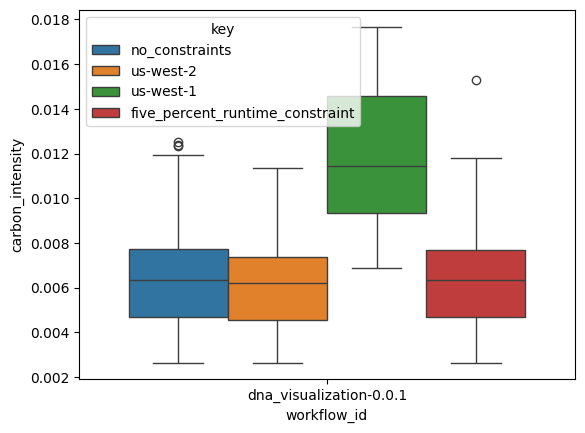

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty DataFrame to store all data
all_data = pd.DataFrame(columns=["workflow_id", "key", "carbon_intensity", "time_key"])

for workflow_id in benchmarks:
    with open(f'./data/deployment_results/{workflow_id}/result_data_points.json', 'r') as f:
        result_data_points = json.load(f)

    # For each key in the data, append the data (carbon intensity) for that key to the DataFrame
    for key, data in result_data_points.items():
        df = pd.DataFrame({
            "workflow_id": [workflow_id] * len(data),
            "key": [key] * len(data),
            "carbon_intensity": [entry["carbon_intensity"] for entry in data],
            "time_key": [entry["time_key"] for entry in data]
        })

        all_data = pd.concat([all_data, df], ignore_index=True)

groouped = all_data.groupby(["workflow_id", "key", "time_key"]).mean()

# Print only where time_key is 0

print(groouped.loc[(slice(None), slice(None), "12"), :])

# Plot all the data in the same plot
sns.boxplot(x="workflow_id", y="carbon_intensity", hue="key", data=all_data)
plt.show()